In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pandas as pd
import numpy as np  
from scipy.stats import rankdata
from scipy import stats
import sys

## Spatial Gradient-based Analysis

To experiment with spatial effects (alone), we used a Dirichlet (constant value) boundary condition with substrate decay to induce a static gradient (after a short transient as substrate diffuses into the computational domain). Approximately half the domain is above the intervention activation threshold when the gradient is at steady-state.

Overall, we find that different interventions take both differing amounts of simulated time to take effect (time to initial population decline) and produce different steady state populations values. This differs from the single-cell Boolean network context, in which the interventions give rise to identical long-term behaviors. 

### Load and process live cell data

This model includes only one population - so we extracted the live cells from each simulation time output. This data was placed in a CSV file. 

Here we load this into a dataframe. These are single simulations (no replicates) so we do not average here. 

In [2]:
df_raw = pd.read_csv('../dataframes/aggregated_live_cells_spatial.csv', index_col=0)
print(df_raw.shape)
df_raw.head()

(28, 481)


,0.0,12.0,24.0,36.0,48.0,60.0,72.0,84.0,96.0,108.0,...,5652.0,5664.0,5676.0,5688.0,5700.0,5712.0,5724.0,5736.0,5748.0,5760.0
intervention,,,,,,,,,,,,,,,,,,,,,
EG_Ceramide_S1P_1_11,1344,1345,1345,1346,1348,1348,1349,1349,1351,1353,...,0,0,0,0,0,0,0,0,0,0
EG_GAP_RAS_1_11,1344,1346,1347,1349,1351,1353,1356,1357,1358,1360,...,0,0,0,0,0,0,0,0,0,0
EG_IL15_GAP_0_11,1344,1347,1349,1351,1352,1353,1353,1353,1355,1355,...,0,0,0,0,0,0,0,0,0,0
EG_IL2RBT_IL2RB_0_11,1344,1345,1347,1350,1352,1353,1353,1355,1355,1356,...,0,0,0,0,0,0,0,0,0,0
EG_IL2RB_MCL1_0_11,1344,1346,1346,1348,1349,1349,1351,1351,1352,1351,...,0,0,0,0,0,0,0,0,0,0


We will mainly be using the transpose of `raw` so lets transpose it. 

In [3]:
df = df_raw.transpose()
df.head(100)

intervention,EG_Ceramide_S1P_1_11,EG_GAP_RAS_1_11,EG_IL15_GAP_0_11,EG_IL2RBT_IL2RB_0_11,EG_IL2RB_MCL1_0_11,EG_JAK_STAT3_0_11,EG_MCL1_BID_0_11,EG_PDGFR_SPHK1_0_11,EG_PI3K_ERK_0_11,EG_RAS_MEK_0_11,...,SM_anti_PDGFR_11,SM_anti_S1P_11,SM_anti_SPHK1_11,SM_pro_Ceramidepro_GRB2_11,SM_pro_Ceramidepro_IL2RBT_11,SM_pro_Ceramidepro_IL2RB_11,SM_pro_Ceramidepro_PI3Kpro_ERK_11,SM_pro_Ceramidepro_PI3Kpro_MEK_11,SM_pro_Ceramidepro_RAS_11,SM_pro_TBETpro_Ceramidepro_ERK_11
0.0,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,...,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344
12.0,1345,1346,1347,1345,1346,1347,1346,1345,1346,1345,...,1345,1345,1345,1346,1347,1345,1344,1344,1344,1344
24.0,1345,1347,1349,1347,1346,1347,1349,1346,1348,1345,...,1348,1346,1346,1346,1347,1345,1345,1345,1345,1346
36.0,1346,1349,1351,1350,1348,1348,1349,1347,1349,1346,...,1350,1349,1347,1346,1348,1349,1348,1346,1346,1349
48.0,1348,1351,1352,1352,1349,1348,1350,1349,1350,1348,...,1352,1349,1348,1347,1350,1353,1349,1349,1347,1350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140.0,21,155,218,15,8,17,0,67,58,94,...,90,25,55,2,1,1,5,3,4,4
1152.0,21,144,199,14,7,15,0,64,55,84,...,86,22,52,2,1,1,5,2,3,3
1164.0,19,130,189,13,6,13,0,64,50,72,...,75,18,49,2,1,1,5,2,3,2
1176.0,14,120,181,10,5,13,0,63,49,69,...,63,15,43,2,1,1,5,1,3,2


Now we have something to plot! Lets chck them out!!

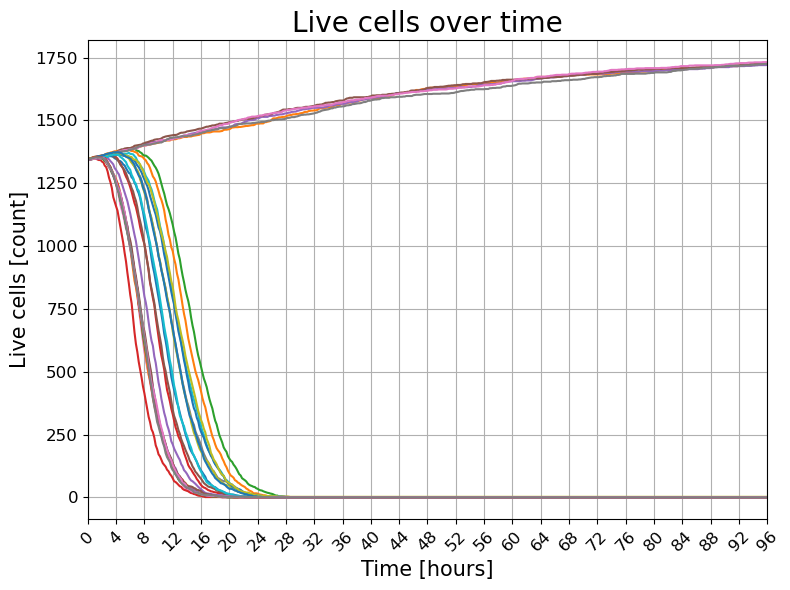

In [4]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

for intervention in df:
    plt.plot(df.index, df[intervention])

plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
# plt.ylim(0, 3200)
plt.xlim(0, df.index[-1])
ticks = np.arange(0, len(df.index), 20)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='both')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))
plt.tight_layout()
plt.savefig('../figures/spatial_all_time_courses.png', dpi=600)
plt.show()

We see that there is both a variety of times at which population death outstrips proliferation as well as the steady state population at the final time point. 

Also, we can see that several interventions fail to control the growth of the population. Given the MaBoSS and Pulsed Interventions Analysis, we suspect these are the IBMFA interventiosn that simply fail to move the survival attractor to an apoptotic attractor. 

For use as needed - here is code to average. Note - averaging may not the right approach doing the correlation analysis

In [5]:
# # Create a new DataFrame to store the averaged values

# df_avg = pd.DataFrame()

# # Process columns in steps of three
# for i in range(0, len(df.columns), 3):
#     # The base name for the averaged column can be derived from the first of each three columns,
#     # removing the last digit and the underscore immediately preceding it.
#     # This needs fixed - jsut need to remove the last digit
#     base_name = df.columns[i][:-1]  # Remove only the last character (replicate number)
#     # print(base_name)
    
#     # Select the three replicate columns
#     replicate_cols = df.iloc[:, i:i+3]
#     # print(replicate_cols)
    
#     # Calculate the average of these columns
#     df_avg[base_name] = replicate_cols.mean(axis=1)

# print(df_avg.shape)
# df_avg.tail()

### Analysis - time to population decline and steady-state population value

Lets find out how long each intervention takes to gain control of the population - the point at which population declines. The ordering of this (on a per intervention basis) is a proxy for how long it takes for an individual cell to become apoptotic and can give us a ranking of interventions in terms of how quickly they act. 

Also, the steady state population will be correlated with this - as interventions that take longer (more updates) to induce apoptosis will enable a longer residence time in the cell-killing zone (the middle region of the simulation in which the intervention threshold is reached)

#### Find the max values, simulated time at maxiumum value, and final value

Find the max value of each column, the time it occurs, and final values. Place them in a dataframe

In [6]:
df_maxv_timemax_finalv = pd.DataFrame()

for column in df:
    max_value = df[column].max()
    max_value_index = df[column].idxmax() 
    final_value = df[column].iloc[-1]
    df_maxv_timemax_finalv[column] = max_value, max_value_index, final_value

# we are going to want to pick up the intervention names for use later - so easier to make them the index
df_maxv_timemax_finalv = df_maxv_timemax_finalv.transpose()

# Nice names
df_maxv_timemax_finalv.columns = ['Max cell count', 'Time at max cell count', 'Final cell count']

# we need numbers - not objects
for column in df_maxv_timemax_finalv:
    df_maxv_timemax_finalv[column] = pd.to_numeric(df_maxv_timemax_finalv[column])

df_maxv_timemax_finalv.describe()
df_maxv_timemax_finalv

,Max cell count,Time at max cell count,Final cell count
EG_Ceramide_S1P_1_11,1360,168.0,0
EG_GAP_RAS_1_11,1384,336.0,0
EG_IL15_GAP_0_11,1387,372.0,0
EG_IL2RBT_IL2RB_0_11,1362,204.0,0
EG_IL2RB_MCL1_0_11,1353,156.0,0
EG_JAK_STAT3_0_11,1362,168.0,0
EG_MCL1_BID_0_11,1358,120.0,0
EG_PDGFR_SPHK1_0_11,1366,192.0,0
EG_PI3K_ERK_0_11,1369,240.0,2
EG_RAS_MEK_0_11,1371,348.0,0


In [7]:
# sort by time at max value

df_maxv_timemax_finalv.sort_values(by='Time at max cell count')

,Max cell count,Time at max cell count,Final cell count
IB_pro_DISC_11,1349,48.0,0
SM_pro_Ceramidepro_IL2RB_11,1353,48.0,0
SM_pro_Ceramidepro_PI3Kpro_ERK_11,1350,60.0,0
SM_pro_Ceramidepro_IL2RBT_11,1352,60.0,0
SM_pro_Ceramidepro_GRB2_11,1352,72.0,0
SM_pro_TBETpro_Ceramidepro_ERK_11,1353,72.0,0
SM_pro_Ceramidepro_RAS_11,1351,84.0,0
SM_pro_Ceramidepro_PI3Kpro_MEK_11,1355,96.0,0
IB_pro_Ceramide_11,1351,96.0,0
EG_MCL1_BID_0_11,1358,120.0,0


Get rid of the inventions that value to control the population

In [8]:
# remove the interventions that are not relevant

df_clean = df_maxv_timemax_finalv[df_maxv_timemax_finalv['Time at max cell count'] < 1440]
df_clean.sort_values(by='Time at max cell count')

,Max cell count,Time at max cell count,Final cell count
SM_pro_Ceramidepro_IL2RB_11,1353,48.0,0
IB_pro_DISC_11,1349,48.0,0
SM_pro_Ceramidepro_PI3Kpro_ERK_11,1350,60.0,0
SM_pro_Ceramidepro_IL2RBT_11,1352,60.0,0
SM_pro_TBETpro_Ceramidepro_ERK_11,1353,72.0,0
SM_pro_Ceramidepro_GRB2_11,1352,72.0,0
SM_pro_Ceramidepro_RAS_11,1351,84.0,0
SM_pro_Ceramidepro_PI3Kpro_MEK_11,1355,96.0,0
IB_pro_Ceramide_11,1351,96.0,0
EG_MCL1_BID_0_11,1358,120.0,0


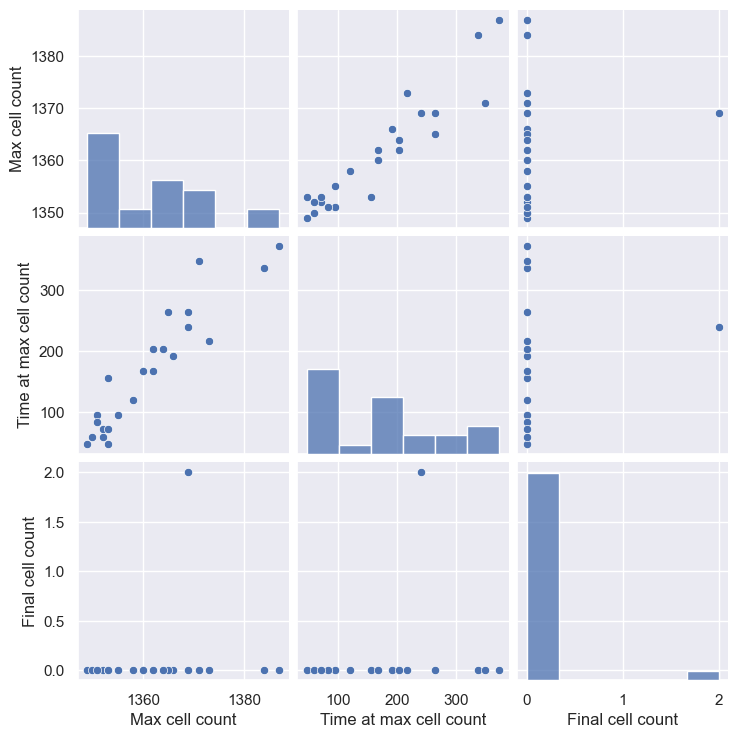

In [9]:
# df_clean.drop('max_value', axis=1, inplace=True)
sns.set_theme()
sns.pairplot(df_clean)

In [10]:
df_clean.head()

,Max cell count,Time at max cell count,Final cell count
EG_Ceramide_S1P_1_11,1360,168.0,0
EG_GAP_RAS_1_11,1384,336.0,0
EG_IL15_GAP_0_11,1387,372.0,0
EG_IL2RBT_IL2RB_0_11,1362,204.0,0
EG_IL2RB_MCL1_0_11,1353,156.0,0


Now we make a nice plot of the data that we are especially interested in.

And cheat and put the correlation so we can use the same plot in other outputs. 

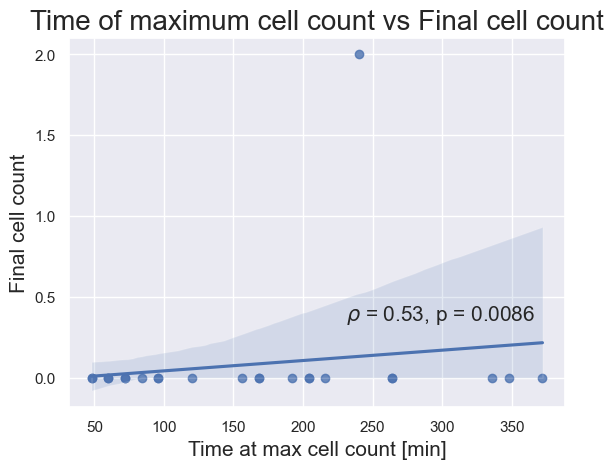

In [11]:
sns.set_theme()
ax = sns.regplot(data=df_clean, x='Time at max cell count', y='Final cell count')
ax.set_title('Time of maximum cell count vs Final cell count', fontsize=20)
ax.set_xlabel('Time at max cell count [min]', fontsize=15)
ax.set_ylabel('Final cell count', fontsize=15)

text = r'$\rho$ = 0.53, p = 0.0086'
ax.text(0.75, 0.25, text, horizontalalignment='center',
     verticalalignment='center', fontsize=15, transform=ax.transAxes)

plt.savefig('../figures/time_at_max_vs_final_cell_count.png', dpi=600)

### Correlation: Spearman

That line is nice - but lets do a statistic on the correlations. In this case, we want to look at the rankings and won't assume the relationship is linear - so we will do Spearman's correlations. 

from scipy import stats


In [12]:
res = stats.spearmanr(df_clean['Time at max cell count'], df_clean['Final cell count'])

print(res)

SpearmanrResult(correlation=0.19318165247793007, pvalue=0.3771487316156359)


We can do a Pearson also - should be similar. 

In [13]:
res = stats.pearsonr(df_clean['Time at max cell count'], df_clean['Final cell count'])

print(res)

PearsonRResult(statistic=0.154073452167973, pvalue=0.48273363201587055)


### Lets plot the rankings!

Get the rankings, then do scatter plot, coloring by one of the rankings. 

In [14]:
ranking_time = rankdata(df_clean['Time at max cell count'])
ranking_final = rankdata(df_clean['Final cell count'])

/var/folders/0_/m923p2192vq__vjqjmt8w8gw0000gn/T/ipykernel_36167/854943715.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


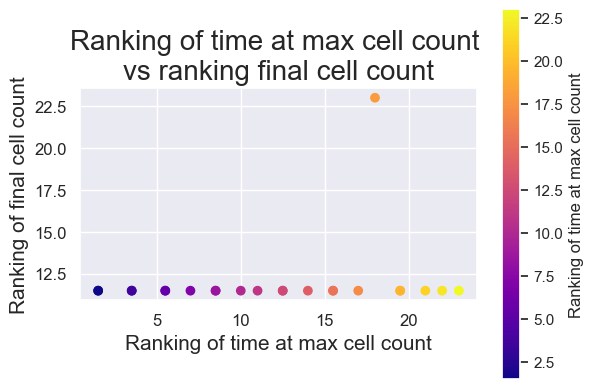

In [15]:
fig, ax = plt.subplots()
plt.scatter(ranking_time, ranking_final, c=ranking_time, cmap='plasma')
plt.xlabel('Ranking of time at max cell count', fontsize=15)
plt.ylabel('Ranking of final cell count', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Ranking of time at max cell count \nvs ranking final cell count', fontsize=20)
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('Ranking of time at max cell count', fontsize=12)
ax.set_aspect('equal')
plt.savefig('../figures/ranking_time_vs_final_cell_count.png', dpi=600)
plt.show()

### Add the ranking to the plot in the original variable space

NOte - doing this in Seaborn may not yield much. Might be cleaner to simply use Matplotlib.

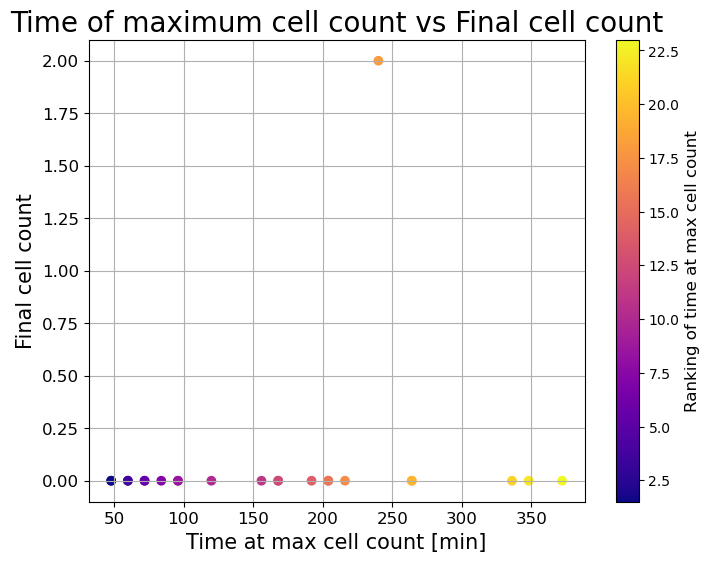

In [16]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df_clean['Time at max cell count'], df_clean['Final cell count'], c=ranking_time, cmap='plasma')
plt.xlabel('Time at max cell count [min]', fontsize=15)
plt.ylabel('Final cell count', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Time of maximum cell count vs Final cell count', fontsize=20)
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('Ranking of time at max cell count', fontsize=12)
# ax.set_aspect('equal')
plt.savefig('../figures/time_at_max_vs_final_cell_count_w_rankings.png', dpi=600)
plt.show()